<a href="https://colab.research.google.com/github/varunkr24/CNN-Image-Classification-1/blob/Python/CNN_Plant_Seedling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import needed libraries
import os as os
from PIL import Image
from array import array
import cv2 as cv2
from glob import glob
import time
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from keras.utils import np_utils
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras import optimizers
from keras.optimizers import Adam
from keras import regularizers
from keras import layers
seed = 7
np.random.seed(seed)

# for API
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation

from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K


In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/

/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1


In [5]:
import os
os.chdir('./train')

In [6]:
os.getcwd()

'/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train'

In [7]:
!ls "/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/"

'Seedling - Prediction'   test	 train


In [8]:
#ScaleTo = 70  # px to scale
#seed = 7  # fixing random
#pathToTrain = '/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/'
#path = '../input/plant-seedlings-classification/train/*/*.png'

pathToTrain = '/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/'

listing = os.listdir( pathToTrain ) 
num_folders = len(listing)
print ( num_folders)
trainArray = [[]]
trainImagesPaths = []
trainImagesCategories = []
trainImg = []
scaleTo = 71
seed = 7

t0=time.time()

for imgFolder in listing:
  print(imgFolder)
  path = '/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/' + imgFolder + '/'
  files = os.listdir( path ) 
  for imgFile in files:
    imgPath = path + imgFile
    trainArray.append([imgPath, imgFolder]) # image path, image folder
    trainImagesPaths.append(imgPath) # paths to images
    trainImagesCategories.append(imgFolder) # labels
    
    trainImg.append(cv2.resize(cv2.imread(imgPath), (scaleTo, scaleTo))) # images
    
t1=time.time()
print(t1-t0," seconds")

12
Black-grass
Scentless Mayweed
Maize
Charlock
Common Chickweed
Common wheat
Loose Silky-bent
Cleavers
Shepherds Purse
Fat Hen
Sugar beet
Small-flowered Cranesbill
1924.0691583156586  seconds


In [9]:
trainImagesPaths[1] # gives the path to the first image

'/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/Black-grass/fc1001932.png'

In [10]:
trainImgNParray = np.asarray(trainImg) # create an array of all the images (not the paths)
trainlabel = pd.DataFrame(trainImagesCategories) # dataframe of all the categories matching each image

In [11]:
# check the length of the training images for confirmation
len(trainImgNParray)

4766

In [12]:
# check the length of labels for confirmation
len(trainlabel)

4766

In [13]:
# checking the shape of the first image.
trainImgNParray[1].shape

(71, 71, 3)

In [14]:
type(trainImgNParray) # verifing the data type

numpy.ndarray

In [15]:
len(trainImagesPaths)

4766

In [16]:
print(trainImagesPaths[0:5])

['/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/Black-grass/fab809601.png', '/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/Black-grass/fc1001932.png', '/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/Black-grass/fef14b865.png', '/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/Black-grass/f39ddbe0a.png', '/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/Black-grass/fb487c5a4.png']


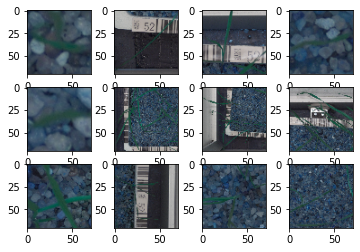

In [17]:
for i in range(12):
  plt.subplot(3,4, i+1)
  plt.imshow(trainImg[i])

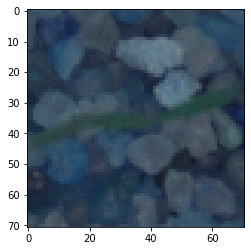

In [18]:
plt.imshow(trainImg[3])

In [19]:
im = trainImg[3]
im.shape

(71, 71, 3)

In [20]:
trainArray[7][0]

'/content/drive/MyDrive/AIML/Projects/CNN/PlantSeedling/Part1/train/Black-grass/f84089a55.png'

In [21]:
trainArray[7][1]

'Black-grass'

In [22]:
trainImgNParray.shape

(4766, 71, 71, 3)

In [23]:
trainlabel.shape

(4766, 1)

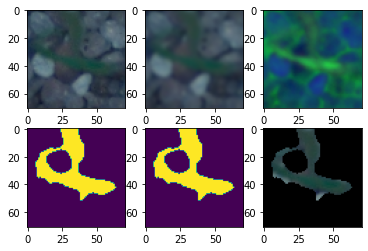

In [24]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImgNParray:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

In [25]:
# normalize the training data
clearTrainImg = clearTrainImg/255

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


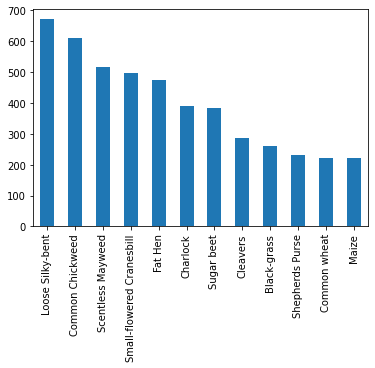

In [26]:
# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainlabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainlabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainlabel[0].value_counts().plot(kind='bar')

In [27]:
# check the data type of the training images
clearTrainImg.dtype

dtype('float64')

In [28]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.10, random_state=seed, 
                                                stratify = clearTrainLabel)

In [29]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

In [36]:
model = Sequential() 
# 2D Convolution layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(scaleTo, scaleTo, 3))) 
model.add(layers.MaxPooling2D((2, 2))) # to downsample the feature maps
# 2D Convolution layer
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
# 2D Convolution layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# 2D Convolution layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu'))

#Add Output Layer
model.add(layers.Dense(num_clases, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_B = model
model_B.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 69, 69, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 128)        

In [37]:
t0=time.time()
history_B = model_B.fit_generator(datagen.flow(trainX, trainY, batch_size=75), epochs=35, validation_data=(testX, testY), verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores_B = model_B.evaluate(testX, testY, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
58/58 - 6s - loss: 2.0319 - accuracy: 0.2821 - val_loss: 1.7857 - val_accuracy: 0.3333
Epoch 2/35
58/58 - 5s - loss: 1.5839 - accuracy: 0.4416 - val_loss: 1.3300 - val_accuracy: 0.5094
Epoch 3/35
58/58 - 5s - loss: 1.3983 - accuracy: 0.5206 - val_loss: 1.2863 - val_accuracy: 0.5367
Epoch 4/35
58/58 - 5s - loss: 1.2658 - accuracy: 0.5654 - val_loss: 1.1769 - val_accuracy: 0.5870
Epoch 5/35
58/58 - 5s - loss: 1.1684 - accuracy: 0.6001 - val_loss: 0.9781 - val_accuracy: 0.6625
Epoch 6/35
58/58 - 5s - loss: 1.0774 - accuracy: 0.6372 - val_loss: 0.9343 - val_accuracy: 0.6709
Epoch 7/35
58/58 - 5s - loss: 0.9711 - accuracy: 0.6720 - val_loss: 0.9561 - val_accuracy: 0.6730
Epoch 8/35
58/58 - 5s - loss: 0.8850 - accuracy: 0.7020 - val_loss: 0.8852 - val_accuracy: 0.7149
Epoch 9/35
58/58 - 5s - loss: 0.8964 - accuracy: 0.7069 - val_loss: 0.8532 - val_accuracy: 0.7212
Epoch 10/35
58/58 - 5s - loss: 0.7863 - accuracy: 0.7354 - val_loss: 0.7029 - val_accuracy: 0.7421
Epoch 11/35
58/58 -

In [38]:
print(model_B.evaluate(trainX, trainY))  # Evaluate on train set
print(model_B.evaluate(testX, testY))  # Evaluate on test set

135/135 [==============================] - 1s 4ms/step - loss: 0.4688 - accuracy: 0.8328
[0.46879950165748596, 0.832828164100647]
15/15 [==============================] - 0s 4ms/step - loss: 0.4789 - accuracy: 0.8260
[0.4788951575756073, 0.8259958028793335]


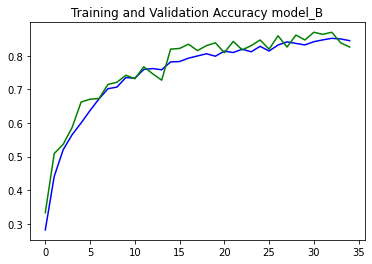

In [39]:
# plot training accuracies
plt.plot(history_B.history['accuracy'],'b') #train acc
plt.plot(history_B.history['val_accuracy'],'g') #val acc
plt.title('Training and Validation Accuracy model_B') 
plt.show()

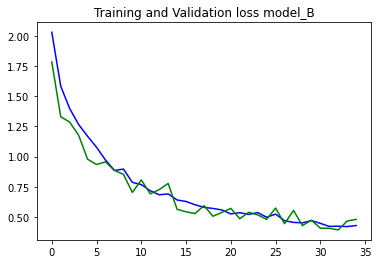

In [40]:
# plot training and validation loss
plt.plot(history_B.history['loss'],'b') #train loss
plt.plot(history_B.history['val_loss'],'g') #val loss
plt.title('Training and Validation loss model_B') 
plt.show()

In [31]:
model = Sequential() 
# 2D Convolution layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(scaleTo, scaleTo, 3))) 
model.add(layers.MaxPooling2D((2, 2))) # to downsample the feature maps
# Normalization layer
model.add(tensorflow.keras.layers.BatchNormalization())
# 2D Convolution layer
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
# Normalization layer
model.add(tensorflow.keras.layers.BatchNormalization()) 
# 2D Convolution layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Normalization layer
model.add(tensorflow.keras.layers.BatchNormalization()) 
# 2D Convolution layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dense(128, activation='relu'))
# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tensorflow.keras.layers.Dropout(0.2))
model.add(tensorflow.keras.layers.Dense(64, activation='relu'))
# Normalization layer
model.add(tensorflow.keras.layers.BatchNormalization())
#Add Output Layer
model.add(layers.Dense(num_clases, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_A = model
model_A.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 69, 69, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 34, 34, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)      

In [32]:
t0=time.time()
history_A = model_A.fit_generator(datagen.flow(trainX, trainY, batch_size=75), epochs=35, validation_data=(testX, testY), verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores = model_A.evaluate(testX, testY, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
58/58 - 38s - loss: 2.0089 - accuracy: 0.3318 - val_loss: 2.7073 - val_accuracy: 0.1405
Epoch 2/35
58/58 - 5s - loss: 1.4780 - accuracy: 0.4978 - val_loss: 3.0244 - val_accuracy: 0.0461
Epoch 3/35
58/58 - 5s - loss: 1.1668 - accuracy: 0.6125 - val_loss: 3.4591 - val_accuracy: 0.0734
Epoch 4/35
58/58 - 5s - loss: 0.9769 - accuracy: 0.6827 - val_loss: 4.6400 - val_accuracy: 0.0503
Epoch 5/35
58/58 - 5s - loss: 0.8427 - accuracy: 0.7277 - val_loss: 4.5024 - val_accuracy: 0.0650
Epoch 6/35
58/58 - 5s - loss: 0.7364 - accuracy: 0.7533 - val_loss: 4.6409 - val_accuracy: 0.0461
Epoch 7/35
58/58 - 5s - loss: 0.6914 - accuracy: 0.7626 - val_loss: 4.4721 - val_accuracy: 0.0461
Epoch 8/35
58/58 - 5s - loss: 0.6523 - accuracy: 0.7764 - val_loss: 3.0347 - val_accuracy: 0.1698
Epoch 9/35
58/58 - 5s - loss: 0.5760 - accuracy: 0.8018 - val_loss: 2.2342 - val_accuracy: 0.2096
Epoch 10/35
58/58 - 5s - loss: 0.5532 - accuracy: 0.8109 - val_loss: 1.9404 - val_accuracy: 0.3732
Epoch 11/35
58/58 

In [33]:
print(model_A.evaluate(trainX, trainY))  # Evaluate on train set
print(model_A.evaluate(testX, testY))  # Evaluate on test set

135/135 [==============================] - 1s 5ms/step - loss: 0.5327 - accuracy: 0.8095
[0.5326552391052246, 0.809512734413147]
15/15 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.7987
[0.6475920677185059, 0.7987421154975891]


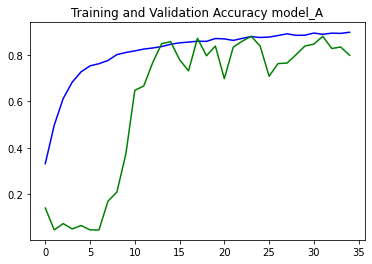

In [34]:
# plot training accuracies
plt.plot(history_A.history['accuracy'],'b') #train acc
plt.plot(history_A.history['val_accuracy'],'g') #val acc
plt.title('Training and Validation Accuracy model_A') 
plt.show()

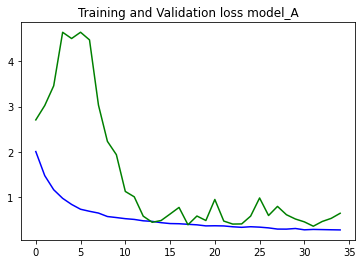

In [35]:
# plot training and validation loss
plt.plot(history_A.history['loss'],'b') #train loss
plt.plot(history_A.history['val_loss'],'g') #val loss
plt.title('Training and Validation loss model_A') 
plt.show()

In [ ]:
import pickle
#1  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(knn)
# Load the pickled model
knn_from_pickle = pickle.loads(saved_model) 
# Use the loaded pickled model to make predictions
knn_from_pickle.predict(X_test)

#2
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)